In [1]:
#!/usr/bin/env python3
# Multislice method.  
#
#   nx, ny, nz:     location of the specimen in pixels
#   pixel_size_nm:  pixel size (nm)
#
#   kvolt:          accelerating voltage (kV)
#   spcm_tilt_rad:  specimen tilting angle (rad)
#   spcm_tilta_rad: specimen tilting axis (rad)
#   beam_tilt_rad:  beam tilting angle (rad)
#   dz_nm:          slice thickness (nm)
#   wvlength_pm:    electron wavelength (pm)
#
#   is_tds:         use thermal diffuse scattering
#
#
#   Exit wave function at each step:
#       psi_n_1(x, y, dz_nm) = exp(6.28318*i*dz_nm / wvlength_pm) * conv(psi_n(x, y, dz_nm), propagator(x, y, dz_nm))
#       propagator(x, y, dz_nm) = -i / wvlength_pm / dz_nm * exp(i*3.14159 / wvlength_pm / dz_nm(x**2 + y**2))
#
#

# Generic imports
import cmath
import numpy as np
import matplotlib.pyplot as plt

# Defined imports
import atomic_potential
import pdb_1 as pdb
import molecular_potential_pdb as mp
import tcif as tcif

# Imports for typing 
from typing import Any, Tuple, List
from nptyping import NDArray

In [2]:
# Parameters ==========
def wvlength_pm(kvolt: int) -> float:
    """Electron wavelength. 
    Args:
        kvolt (int): accelerating voltage in kV
    Returns:
        float: wavelength in pm
    """
    return 1.23e3 / cmath.sqrt(kvolt*1e3 * (1 + 9.78e-7*kvolt*1e3))


def sigma(kvolt: float) -> float:
    """Interaction coefficient of an electron.  $$\sigma _e = 2 \pi m e \lambda / h^2$$
    Args:
        kvolt (float): accelerating voltage in kV.
    Returns:
        float: interaction coefficient of an electron. 
    """
    return 2.08847e6 * wvlength_pm(kvolt)

In [3]:
# Entrance ==========
pdb_file = "1dat_10_atoms.pdb"
box_size = 30
pxel_size_nm = 0.105 # 0.105
trgt_slice_nm = 0.3 # 0.3
kvolt = 300.0

slce_zpixels = trgt_slice_nm // pxel_size_nm
total_slice_number = int(box_size // slce_zpixels + 1)

protein = pdb.PDB(pdb_file)     # used to be protein = pdb.PDB(pdb_file).read_pdb()
# Read the atoms from the PDB file
protein.read_pdb()  

# Check if the box size is large enough for the PDB structure
# Get the min and max coordinates of the atoms in the PDB file
min_x = min(atom.x for atom in protein.atoms)
max_x = max(atom.x for atom in protein.atoms)
min_y = min(atom.y for atom in protein.atoms)
max_y = max(atom.y for atom in protein.atoms)
min_z = min(atom.z for atom in protein.atoms)
max_z = max(atom.z for atom in protein.atoms)

# Calculate the physical size of the box in each dimension (in nanometers)
box_size_nm = box_size * pxel_size_nm  # Convert box size to nm
box_size_angstrom = box_size_nm * 10  # Convert nanometers to angstroms (Å)

# Print the results to see if the box is big enough
print(f"Box size: {box_size_nm:.2f} nm ({box_size_angstrom:.2f} Å), {box_size} pixels")
print(f"PDB structure dimensions: X: {min_x:.2f} Å to {max_x:.2f} Å, Y: {min_y:.2f} Å to {max_y:.2f} Å, Z: {min_z:.2f} Å to {max_z:.2f} Å")

# Compare the dimensions of the structure to the box size
if (max_x - min_x) > box_size_angstrom or (max_y - min_y) > box_size_angstrom or (max_z - min_z) > box_size_angstrom:
    print("Warning: The PDB structure is larger than the box. Consider increasing the box size.")
else:
    print("The PDB structure fits within the box.")

# Calculate molecular potential
mol_potential = mp.integrate_atomic_potential(protein, box_size, pxel_size_nm)
# Scale the molecular potential  
mol_potential *= 1e20


print(f"mol_potential min: {np.min(mol_potential)}, max: {np.max(mol_potential)}")



deltaZ = slce_zpixels * pxel_size_nm
box_center = box_size / 2
propagator_r = np.zeros((box_size, box_size), dtype=complex) # used to be propagator_r = np.zeros((box_size, box_size))
propagator_i = np.zeros((box_size, box_size), dtype=complex) # used to be propagator_i = np.zeros((box_size, box_size))
for m in range(box_size):
    for n in range(box_size):
        rsq_ = (m - box_center)**2 + (n - box_center)**2
        rsq_ = rsq_ * pxel_size_nm**2
        prop_phs = 3.14159 / wvlength_pm(kvolt) / deltaZ * rsq_ * 1e3
        c1 = 1 / wvlength_pm(kvolt) / deltaZ * 1e21

        propagator_r[m, n] = propagator_r[m, n] + c1 * cmath.sin(prop_phs)
        propagator_i[m, n] = propagator_i[m, n] + c1 * cmath.cos(prop_phs)

# Initialize the incident wave function $$\psi _0 (x, y) = 1$$
psi_r = np.ones((box_size, box_size))
psi_i = np.zeros((box_size, box_size))

for slc in range(total_slice_number):
    # Procedure (page 181)
    # Divide the specimen into thin slices and integrate them along z axis
    slce_start = int(slc * slce_zpixels)

    if slc != (total_slice_number - 1):
        slc_end = int(slce_start + slce_zpixels)
    else:
        slc_end = int(box_size)
        
    v_n = np.array(mol_potential[:, :, slce_start:slc_end])
    v_nz = np.sum(v_n, axis=2)      # need to check the axis here ### Po-Lin originally had 0

    # Transmission function
    tr_n = np.cos(sigma(kvolt)*v_nz)
    ti_n = np.sin(sigma(kvolt)*v_nz)

    print(f"v_nz min: {np.min(v_nz)}, max: {np.max(v_nz)}")
    print(f"tr_n min: {np.min(tr_n)}, max: {np.max(tr_n)}")
    print(f"ti_n min: {np.min(ti_n)}, max: {np.max(ti_n)}")
    
    # Recursively transmit and propagate the wave function through each slice
    # Propagator: Eq. (6.65) on page 165
    t_psi_r = tr_n * psi_r - ti_n * psi_i
    t_psi_i = ti_n * psi_r + tr_n * psi_i

    prpg_n = propagator_r + 1j * propagator_i
    trns_n = t_psi_r + 1j * t_psi_i

    ####### Normalize values to avoid overflow
    prpg_n /= np.max(np.abs(prpg_n)) + 1e-10  # Add a small value to avoid division by zero
    trns_n /= np.max(np.abs(trns_n)) + 1e-10  # Similarly scale trns_n
    ######

    psi_n1 = np.fft.ifft2(np.fft.fft2(prpg_n) * np.fft.fft2(trns_n))

    psi_r = psi_n1.real
    psi_i = psi_n1.imag

# psi_r and psi_i is the final exit wave for the real and imaginary parts, respectively. 
# Pass the final exit wave function to the TCIF if the specimen is tilted
# or to the CTF if the specimen is untilted. 
   

Read number of atoms from the PDB: 10
Shift the coordinates according to the gravity center of the molecule.
Box size: 3.15 nm (31.50 Å), 30 pixels
PDB structure dimensions: X: -2.12 Å to 2.68 Å, Y: -1.87 Å to 2.47 Å, Z: -1.88 Å to 2.05 Å
The PDB structure fits within the box.
mol_potential min: (0.006805235495577517+0j), max: (1874.1265985951538+0j)
v_nz min: (0.015090807358554965+0j), max: (0.9168913355491629+0j)
tr_n min: (-0.9999646072376976-0j), max: (0.9999912324825528-0j)
ti_n min: (-0.9999917755267687+0j), max: (0.9999971564721891+0j)
v_nz min: (0.021934280760833005+0j), max: (2.0404542274779147+0j)
tr_n min: (-0.9999979599655767-0j), max: (0.999955128251138-0j)
ti_n min: (-0.9999966466742571+0j), max: (0.9999986375846501+0j)
v_nz min: (0.03059109249754695+0j), max: (4.695345572022044+0j)
tr_n min: (-0.9999999969880284-0j), max: (0.9999915039293429-0j)
ti_n min: (-0.9999991150317575+0j), max: (0.9999999985965179+0j)
v_nz min: (0.04069112839045402+0j), max: (11.289555870456187+0

In [4]:
print(psi_r)
print(f"psi_r min: {np.min(psi_r)}, max: {np.max(psi_r)}")

[[ -5.09418049   4.99994122  -1.51583278  -3.37985173  20.80023675
   -8.42593464  -7.03616356   9.41614732  -3.04130825   8.2637168
  -10.33119458  11.67104377  16.30063011  -1.39605662  -3.52862679
    8.56053929 -13.21324165  17.09830907   0.10010468  -4.78973745
   13.38583389   2.4389318   -2.69593174 -10.41789375   3.77727773
    6.97627297  10.19878674 -13.44024359  16.27546733   4.17616651]
 [ 13.69202697 -10.26418871  13.42803578   2.94655642 -14.20412661
   17.04753024 -13.28459043   0.84403929   0.45133826  -2.02844224
    9.23335875  -2.0655997   18.60373438  -3.81288864 -13.27788369
   26.44756911  -8.99826437   5.56909007   7.27129299  -5.77911464
   14.80378853 -12.16566272   9.59041392   2.19575334  -6.70549604
   22.00386683  -9.23310116  -0.29151094  13.22408623   2.28990336]
 [  7.43547848 -18.92517273  17.62589011  -9.84009376  -7.27316059
   16.59725813  -7.32583428   7.43005592   2.69499966  -1.82494093
   -5.25092096  14.16277512   7.49377746 -11.19784186  -3.028

In [5]:
print(psi_i)
print(f"psi_i min: {np.min(psi_i)}, max: {np.max(psi_i)}")


[[ 6.35094910e+00  1.84174550e+01  2.61033700e-01  2.07992438e+01
   1.48471322e+01  4.77350538e-02  1.44814313e+01 -2.74323355e+00
   2.77086247e+01  4.49188259e+00 -7.06060145e+00  3.12907458e+00
   1.19772670e+01 -7.63261609e-01  8.02182756e+00  7.06478033e+00
   6.81920187e-01  1.50938328e+01  1.42090900e+01  7.09656402e+00
   1.48330536e+01  1.48566000e+01  3.93575208e+00  6.03334276e+00
  -4.86084051e+00  3.00366910e+01 -4.67687776e+00 -6.27755904e+00
   1.43851252e+01 -9.19914811e+00]
 [-1.30664037e+01 -4.97136159e+00  3.86238660e+00  3.25558585e+00
  -5.58924810e+00 -1.41721102e+01 -1.73794331e+00 -5.68010471e+00
   1.18747183e+00  8.88426738e+00 -1.26145092e+01 -1.04903511e+01
  -7.74261409e+00  1.43945031e+01 -2.22698927e+01 -8.66781014e+00
   2.72376544e+01 -2.06733943e+01  3.17937744e+00  5.41492672e+00
  -7.43387590e+00  1.17759476e+01 -1.45008806e+01  1.03300817e+00
   1.67973264e+00 -2.18596706e+01  2.34045189e+01 -2.85803525e+01
  -1.91987926e+01  2.59599038e+01]
 [ 1.6

In [6]:
#####
imge_size = 30 # comes from psi_r shape
alpha_rad = np.deg2rad(5.0)
beta_rad = 0 # tilt axis is the x-axis
df1_nm = 1000
df2_nm = 1000
Cs = 2.7
psi_complex = psi_r + 1j * psi_i

In [7]:
print(psi_complex)

[[ -5.09418049+6.35094910e+00j   4.99994122+1.84174550e+01j
   -1.51583278+2.61033700e-01j  -3.37985173+2.07992438e+01j
   20.80023675+1.48471322e+01j  -8.42593464+4.77350538e-02j
   -7.03616356+1.44814313e+01j   9.41614732-2.74323355e+00j
   -3.04130825+2.77086247e+01j   8.2637168 +4.49188259e+00j
  -10.33119458-7.06060145e+00j  11.67104377+3.12907458e+00j
   16.30063011+1.19772670e+01j  -1.39605662-7.63261609e-01j
   -3.52862679+8.02182756e+00j   8.56053929+7.06478033e+00j
  -13.21324165+6.81920187e-01j  17.09830907+1.50938328e+01j
    0.10010468+1.42090900e+01j  -4.78973745+7.09656402e+00j
   13.38583389+1.48330536e+01j   2.4389318 +1.48566000e+01j
   -2.69593174+3.93575208e+00j -10.41789375+6.03334276e+00j
    3.77727773-4.86084051e+00j   6.97627297+3.00366910e+01j
   10.19878674-4.67687776e+00j -13.44024359-6.27755904e+00j
   16.27546733+1.43851252e+01j   4.17616651-9.19914811e+00j]
 [ 13.69202697-1.30664037e+01j -10.26418871-4.97136159e+00j
   13.42803578+3.86238660e+00j   2.9465

In [8]:
print("Calling W_0 function...")
W_0_array = tcif.W_0(Cs, wvlength_pm(kvolt), df1_nm, df2_nm, beta_rad, imge_size, pxel_size_nm)

Calling W_0 function...


/Users/kiradevore/Documents/python_scripts/Tilt-Contrast-Imaging-main/tcif.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  start[i, j] = start[i, j] + 6.28318 * (W21 + W22)


In [9]:
print(W_0_array)

[[54145094.42828313 53904422.94565111 53664821.1697029  53426285.53059706
  53188812.46645188 52952398.42334495 52717039.85531349 52482733.22435417
  52249475.00042323 52017261.66143639 51786089.6932689  51555955.58975547
  51326855.85269042 51098786.9918275  50871745.52487994 50645727.97752067
  50420730.88338187 50196750.78405547 49973784.22909275 49751827.77600458
  49530877.9902613  49310931.44529284 49091984.7224885  48874034.41119726
  48657077.10872752 48441109.42034718 48226127.9592837  48012129.34672397
  47799110.21181457 47587067.19166137]
 [53904422.94565111 53664287.53684818 53425220.64212874 53187218.69165145
  52950278.12353447 52714395.38385544 52479566.92665162 52245789.21391966
  52013058.71561582 51781371.90965573 51550725.28191473 51321115.32622752
  51092538.54438838 50864991.44615107 50638470.5492289  50412972.37929465
  50188493.46998066 49965030.36287872 49742579.60754019 49521137.76147594
  49300701.39015628 49081267.06701113 48862831.37342986 48645390.89876141

In [10]:
print("Calling tcif function...")
QP_amp, QP_phs = tcif.tcif(psi_complex, W_0_array, beta_rad, alpha_rad, wvlength_pm(kvolt), imge_size, pxel_size_nm)

Calling tcif function...
Spatial frequencies: [-4.76190476 -4.44444444 -4.12698413 -3.80952381 -3.49206349 -3.17460317
 -2.85714286 -2.53968254 -2.22222222 -1.9047619  -1.58730159 -1.26984127
 -0.95238095 -0.63492063 -0.31746032  0.          0.31746032  0.63492063
  0.95238095  1.26984127  1.58730159  1.9047619   2.22222222  2.53968254
  2.85714286  3.17460317  3.49206349  3.80952381  4.12698413  4.44444444]
f_spec [[-4.92969818e+00+1.02851982e+01j  1.06822008e+01+4.86281679e+01j
  -1.49537516e+01-1.37800031e+00j -1.74533009e+01+1.40758596e+01j
   1.08861813e+01+6.22277464e+01j  1.09572837e+01+1.11412716e+01j
  -1.16284113e+02+5.59470499e+01j  1.56107604e+00-7.68620101e-02j
  -8.17486386e+01+3.08066044e-01j -1.17679543e+01-2.82045945e+00j
   3.10992803e+01+2.11624801e+01j -3.04939899e+01+1.73983987e+01j
  -3.16787646e+01+1.19201103e+01j -7.69315304e-01+3.29397984e+01j
   3.82567640e+01-1.47525655e+01j  6.49033220e+01+3.46905695e+01j
  -8.05051429e+00+7.00325408e+00j  3.26027035e+01-3.4

/Users/kiradevore/Documents/python_scripts/Tilt-Contrast-Imaging-main/tcif.py:166: ComplexWarning: Casting complex values to real discards the imaginary part
  amp[i, j] = amp[i, j] + cmath.sqrt(Q3r**2 + Q3i**2)
/Users/kiradevore/Documents/python_scripts/Tilt-Contrast-Imaging-main/tcif.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  phs[i, j] = phs[i, j] + cmath.atan(Q3i / Q3r)


sx: -4.444444444444445 sy: -3.492063492063492
sx: -4.444444444444445 sy: -3.1746031746031744
sx: -4.444444444444445 sy: -2.8571428571428568
sx: -4.444444444444445 sy: -2.5396825396825395
sx: -4.444444444444445 sy: -2.2222222222222223
sx: -4.444444444444445 sy: -1.9047619047619047
sx: -4.444444444444445 sy: -1.5873015873015872
sx: -4.444444444444445 sy: -1.2698412698412698
sx: -4.444444444444445 sy: -0.9523809523809523
sx: -4.444444444444445 sy: -0.6349206349206349
sx: -4.444444444444445 sy: -0.31746031746031744
sx: -4.444444444444445 sy: 0.0
sx: -4.444444444444445 sy: 0.31746031746031744
sx: -4.444444444444445 sy: 0.6349206349206349
sx: -4.444444444444445 sy: 0.9523809523809523
sx: -4.444444444444445 sy: 1.2698412698412698
sx: -4.444444444444445 sy: 1.5873015873015872
sx: -4.444444444444445 sy: 1.9047619047619047
sx: -4.444444444444445 sy: 2.2222222222222223
sx: -4.444444444444445 sy: 2.5396825396825395
sx: -4.444444444444445 sy: 2.8571428571428568
sx: -4.444444444444445 sy: 3.17460317

In [11]:
print(QP_amp)

[[7.11310962e+00 4.34306382e+01 1.44532264e+01 3.47769949e+01
  7.30082323e+01 2.26359441e+01 1.25000167e+02 1.41343238e+00
  7.87456215e+01 1.60289877e+01 4.95900513e+01 3.55079632e+01
  3.59060697e+01 3.04366329e+01 3.75306023e+01 1.09609771e+02
  1.46801602e+01 5.26268379e+01 9.39595446e+00 1.65175657e+01
  7.33545927e+01 1.23124326e+01 1.06753737e+02 4.85523491e+00
  4.81613802e+01 3.19748967e+01 2.48463520e+01 1.60163555e+02
  1.05810328e+01 3.85411214e+01]
 [8.75593755e+01 5.52216552e+02 1.29746942e+01 5.22226679e+02
  2.68561613e+01 2.62923482e+02 2.40899709e+01 7.52097848e+01
  5.02061290e+02 2.62444445e+02 1.69736851e+03 1.80464615e+02
  1.16803864e+02 5.84975214e+02 2.13167799e+02 2.26150684e+03
  5.13816269e+02 2.34089989e+02 1.39899384e+02 3.70240867e+02
  9.71763759e+02 3.16205448e+02 6.08648851e+02 3.02404285e+01
  4.12270332e+02 1.48083792e+01 1.41017263e+03 1.99393476e+03
  9.85995219e+01 4.48886477e+02]
 [6.81729993e+00 8.80472629e+01 5.00646283e+01 2.50240046e+02
  9.

In [12]:
print(QP_phs)

[[-3.30786222e-01 -1.51948065e+00 -1.03514461e+00  3.47325219e-01
  -2.20117372e-01 -7.44217256e-01  1.02996956e+00  1.15323909e-01
  -4.01656526e-01  6.11931972e-01 -3.77461761e-01 -9.09015144e-01
   1.52334980e-01  4.29663671e-01 -2.05634408e-01 -1.01133964e+00
   1.40746110e+00  8.99746327e-01  1.04283812e+00 -1.05002194e+00
  -3.81635292e-01  1.40479735e+00 -3.43574725e-02 -3.78480335e-01
   1.47241120e+00  8.55250997e-01  1.55408438e+00  1.32687137e+00
  -5.41058393e-01 -1.85840027e-01]
 [-9.65739760e-01 -8.64307983e-01 -8.01684137e-01 -1.18612053e+00
   3.11262822e-01 -1.44432832e+00  9.52075358e-01  1.00014248e+00
  -8.52584403e-01 -8.28386712e-02 -4.44463427e-01 -1.20777105e+00
  -1.08057330e+00  1.44112319e-01 -1.00385971e+00  1.10259614e+00
  -1.24616721e-01 -1.47819809e-01  4.14215922e-01  1.14140513e+00
   1.47032895e+00  1.50846368e+00  1.42509481e-01  7.41355789e-01
   2.46435636e-01  8.81616724e-01  1.00229598e+00  1.13238909e+00
  -1.56587093e+00  7.71881830e-01]
 [ 1.3

In [13]:
print("Calling tcif transform function...")
real_space_image = tcif.tcif_transform(QP_amp, QP_phs)
print(real_space_image.dtype)

Calling tcif transform function...
complex128


Plotting...


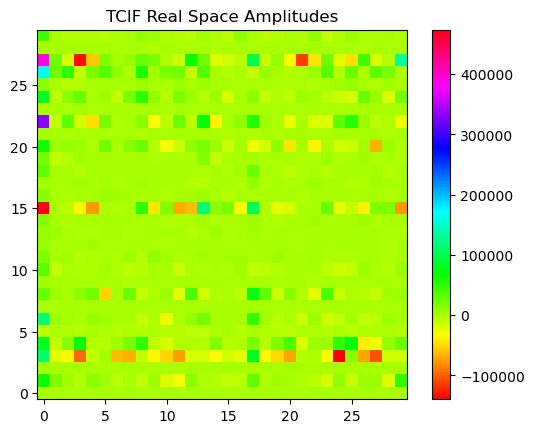

In [14]:
print("Plotting...")
plt.imshow(real_space_image.real, cmap='hsv') 
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("TCIF Real Space Amplitudes")
plt.show()

Plotting...


/var/folders/w0/vg892c2916v_sm1r97812m940000gn/T/ipykernel_37860/1885025722.py:2: RuntimeWarning: invalid value encountered in log
  db = -20 * np.log(real_space_image.real)


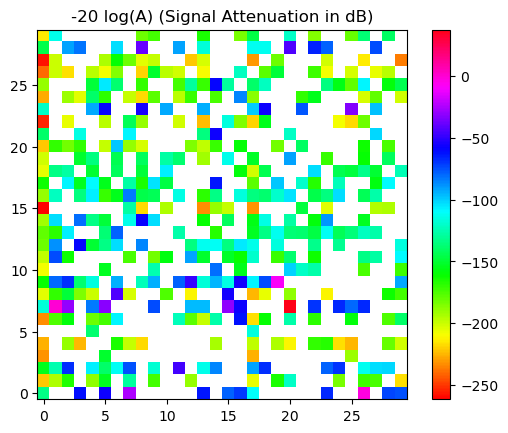

In [15]:
print("Plotting...")
db = -20 * np.log(real_space_image.real)
plt.imshow(db, cmap='hsv') 
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("-20 log(A) (Signal Attenuation in dB)")
plt.show()

Plotting...


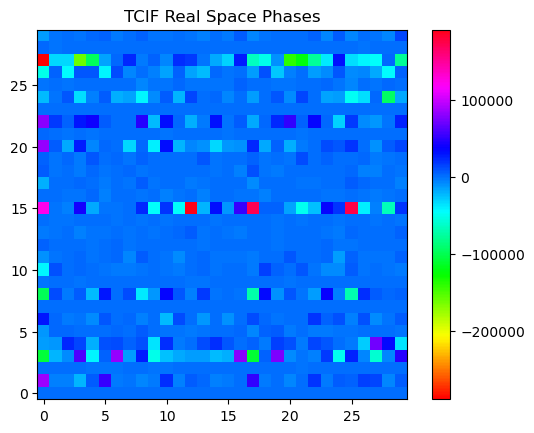

In [16]:
print("Plotting...")
plt.imshow(real_space_image.imag, cmap='hsv') 
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("TCIF Real Space Phases")
plt.show()